# Imports

In [ ]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot

# tells matplotlib to embed plots within the notebook
%matplotlib inline

# Pytorch
import torch

# modules to dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

# modules to adequate the NN
from torch import nn
from torch import optim

# Measuring execution time
import time

#Bibliotecas para receber o upload e usar a imagem no predict
from ipywidgets import widgets
from PIL import Image
from io import BytesIO
from google.colab import files

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Configurando a GPU

In [ ]:
def testar_gpu():
	train_on_gpu = torch.cuda.is_available() #Observa se a GPU está disponivel
	if train_on_gpu: #Se sim
		device = torch.device('cuda') #Seleciona o device como GPU
		print("Treinando na GPU") #E manda a mensagem
	else: #Se não
		device = torch.device('cpu') #Seleciona o device como cpu
		print("GPU indisponível, treinando na CPU") #E avisa que a GPU não esta disponível
	return device

device = testar_gpu()

Treinando na GPU


# Montagem do DataSet

In [ ]:
transform = transforms.Compose([transforms.Resize((100,100)), transforms.ToTensor()])
data = ImageFolder('Caminho da base de dados', transform=transform)

print('Total de imagens no dataset:', len(data))
percentage = 70 # Porcentagem dos dados que vão ser utilizado no treinamento
n_treino = round(len(data)* (percentage/100))
n_teste = round(len(data)* (100 - percentage)/(2*100))
n_valid = len(data) - n_treino - n_teste

print('nº de imagens para treino: {:}'.format(n_treino) +'; nº de imagens para teste: {:}'.format(n_teste) +'; nº de imagens para validação: {:}'.format(n_valid) + '.')
data_train, data_test, data_valid = random_split(data, [n_treino, n_teste, n_valid], generator=torch.Generator().manual_seed(42))

Total de imagens no dataset: 1000
nº de imagens para treino: 700; nº de imagens para teste: 150; nº de imagens para validação: 150.


# Batch Size

In [ ]:
batch_size = 750 # Definir o o tamanho de cada batch de treino

loader_train  = DataLoader(data_train, batch_size= batch_size)
loader_test = DataLoader(data_test, batch_size = 1)
loader_valid = DataLoader(data_valid, batch_size = 1)

# Definição da rede neural e seus parâmetros

In [ ]:
model = models.resnet152(pretrained=True)
print(model)
for param in model.parameters():
  param.requires_grad = False

classifier = nn.Sequential(nn.Linear(2048,512),
                           nn.ReLU(),
                           nn.Dropout(p=0.2),
                           nn.Linear(512,128),
                           nn.ReLU(),
                           nn.Dropout(p=0.2),
                           nn.Linear(128,2),
                           nn.LogSoftmax(dim=1))  # Alterando o classificador padrão da rede neural

model.fc = classifier

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [ ]:
lr = 0.00005 # Learning Rate
epochs = 100  # Número de épocas  (Quantos ciclos de treinamento)

criterion = nn.NLLLoss()  #Função custo
optimizer = torch.optim.AdamW(model.fc.parameters(), lr=lr) #F unção de otimização

list_train_loss = []
list_test_loss = []
list_acc = []

model = model.to(device)

# Algoritmo de treinamento

In [ ]:
START = time.time()

for epoch in range(1, epochs+1):
	start = time.time()
	
	# Etapa de Treino
	model.train()
	loss_train = 0
 
	for imagem_treino,label_treino in loader_train:

		loss = 0

		imagem_treino, label_treino = imagem_treino.float().to(device), label_treino.to(device)	#	Coloca as imagens na GPU
		outputs = model(imagem_treino)	#	Gera as probabilidades
		loss = criterion(outputs, label_treino.float().long())	#	Pegando Loss

		optimizer.zero_grad() #	Zera o gradiente para que ele não seja constantemente acumulado na backpropragation que vem a seguir
		loss.backward() #	Realiza a backpropragation
		optimizer.step() #	Realiza mais um passo dentro do gradiente
		loss_train += loss	#Adiciona ao somatório
	
	loss_train = loss_train/len(loader_train)	#	Pega o somatório e divide pelo tamanho do dataset
	list_train_loss.append(loss_train.item()) #	Guarda o valor da função de perda

	# Etapa de Teste
	model.eval()
	correct = 0
	total = 0
	loss_test = 0
	
	with torch.no_grad():
		for imagem_teste, label_teste in loader_test:

			imagem_teste, label_teste = imagem_teste.float().to(device), label_teste.to(device)	#	Colocar as imagens na GPU
			outputs_test = model(imagem_teste)	#	Gera as probabilidades
	 
			_,previsao = torch.max(outputs_test, dim = 1)	# Pega a posição do maior valor dentre os valores
			loss_test += criterion(outputs_test, label_teste.long())	#	Adiciona ao somatório de erro
			total = total + 1 #	Adiciona +1 na variável que guarda o total de previsões feitas
			
			if previsao == label_teste: 
				correct = correct + 1 #Soma +1 na variável que mede quantas previsões dessa categoria (erro absoluto de 2 graus) estão certas
		
		loss_test = loss_test/len(loader_test)	#	Pega o somatório e divide pelo tamanho do dataset
		list_test_loss.append(loss_test.item())	#	Guarda o valor da função de perda numa lista

	acc = (correct/total)*100 #Calcula a acurácia para erro absoluto de 1 grau em porcentagem
	list_acc.append(acc) #Adiciona essa acurácia a sua lista

	end = time.time()
	Time = end - start	# Pega o tempo que demorou em segundos

	if epoch < 10:
		print('Epoch: ', epoch ,' loss: {:.4f}'.format(loss_test.item()), ' Accuracy: {:.2f}'.format(acc), ' Time spent this epoch: {:.2f}'.format(Time), 'seconds.')
	else:
		print('Epoch:', epoch ,' loss: {:.4f}'.format(loss_test.item()), ' Accuracy: {:.2f}'.format(acc), ' Time spent this epoch: {:.2f}'.format(Time), 'seconds.')

END = time.time()

print()
TIME = END - START
print('\n Time spent during training: {:.2f}'.format(TIME), 'seconds')

Epoch:  1  loss: 0.6971  Accuracy: 48.00  Time spent this epoch: 10.54 seconds.
Epoch:  2  loss: 0.6965  Accuracy: 46.67  Time spent this epoch: 10.85 seconds.
Epoch:  3  loss: 0.6963  Accuracy: 51.33  Time spent this epoch: 10.05 seconds.
Epoch:  4  loss: 0.6963  Accuracy: 49.33  Time spent this epoch: 10.03 seconds.
Epoch:  5  loss: 0.6962  Accuracy: 42.67  Time spent this epoch: 10.06 seconds.
Epoch:  6  loss: 0.6961  Accuracy: 44.67  Time spent this epoch: 10.05 seconds.
Epoch:  7  loss: 0.6957  Accuracy: 43.33  Time spent this epoch: 10.05 seconds.
Epoch:  8  loss: 0.6949  Accuracy: 46.67  Time spent this epoch: 10.41 seconds.
Epoch:  9  loss: 0.6939  Accuracy: 48.00  Time spent this epoch: 10.06 seconds.
Epoch: 10  loss: 0.6925  Accuracy: 49.33  Time spent this epoch: 10.04 seconds.
Epoch: 11  loss: 0.6907  Accuracy: 52.00  Time spent this epoch: 10.09 seconds.
Epoch: 12  loss: 0.6887  Accuracy: 54.67  Time spent this epoch: 10.10 seconds.
Epoch: 13  loss: 0.6863  Accuracy: 56.67

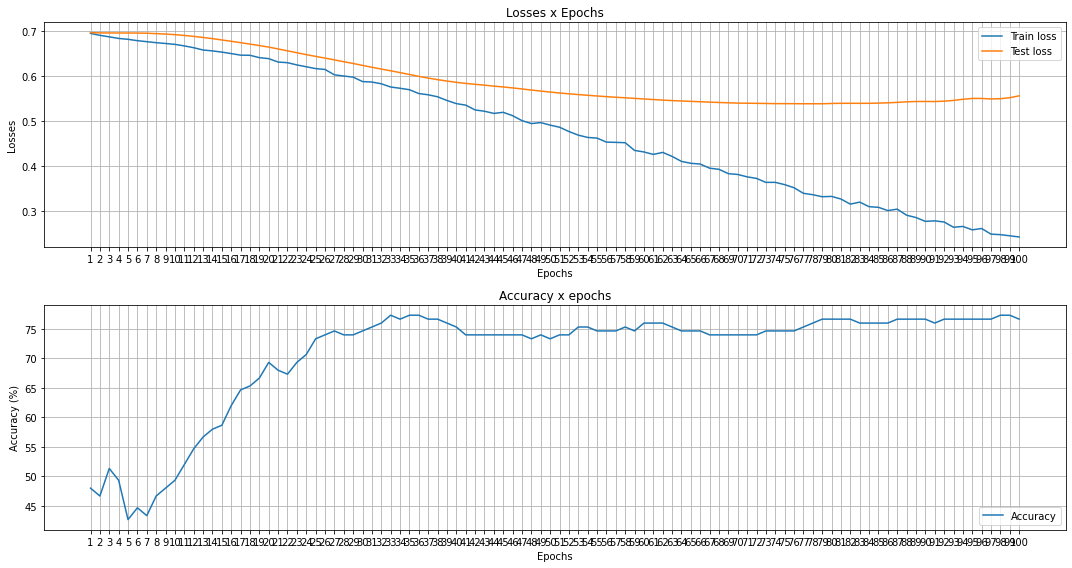

In [ ]:
fig, axs = pyplot.subplots(2, figsize=(15,8))
axs[0].plot(range(1, epochs+1), list_train_loss,label="Train loss") #Plota o erro de treino X epocas
axs[0].plot(range(1, epochs+1), list_test_loss, label="Test loss") #Plota o erro de teste x epocas
axs[0].set(xticks=range(1, epochs+1))
axs[0].set_title('Losses x Epochs') #Define o título
axs[0].set(xlabel='Epochs') #Define o nome do eixo x
axs[0].set(ylabel='Losses') #Define o nome do eixo y
axs[0].legend() #Mostra a legenda
axs[0].grid(True) #Mostra a grade


axs[1].plot(range(1, epochs+1), list_acc, label='Accuracy') #Plota a acuracia para erro de 1 graus x epocas
axs[1].set(xticks=range(1, epochs+1))
axs[1].set_title('Accuracy x epochs') #Define o título
axs[1].set(xlabel='Epochs') #Define o nome do eixo x
axs[1].set(ylabel='Accuracy (%)') #Define o nome do eixo y
axs[1].legend(loc='lower right') #Mostra a legenda
axs[1].grid(True) #Mostra a grade

pyplot.tight_layout()

# Algoritmo de validação

In [ ]:
total = 0
correct = 0
loss_valid = 0

for imagem_valid, label_valid in loader_valid:

	loss_v = 0
 
	imagem_valid, label_valid = imagem_valid.float().to(device), label_valid.to(device)	# Coloca a imagem na GPU
	outputs_valid = model(imagem_valid) # Realiza o Feedfoward
	_, previsao = torch.max(outputs_valid, dim = 1)	# Pega o maior valor do vetor
	loss_v = criterion (outputs_valid, label_valid.long())	#	Pega o loss
	total = total + 1 #	Adiciona +1 na variável que guarda o total de previsões feitas
	if previsao == label_valid: 
		correct = correct + 1 #	Soma +1 na variável que mede quantas previsões dessa categoria (erro absoluto de 2 graus) estão certas
	loss_valid += loss_v	#	Adiciona ao somatório dos erros

loss_valid = loss_valid/len(loader_valid) #	Pega o somatório e divide pelo tamanho do dataset
accuracy = (correct/total)*100 #	Calcula a acurácia para erro absoluto de 1 grau em porcentagem

print('A acurácia obtida foi de: {:.2f}'.format(accuracy) + '%.', end='\n\n')
print('O erro médio obtido foi de: {:.4f}'.format(loss_valid), end='\n\n')
print('O tempo gasto durante o treinamento, excluindo a primeira época, foi de: {:.2f}'.format(TIME), 'segundos.', end='\n\n')

A acurácia obtida foi de: 70.00%.

O erro médio obtido foi de: 0.6076

O tempo gasto durante o treinamento, excluindo a primeira época, foi de: 1007.86 segundos.



In [ ]:
torch.save(model, 'Caminh que deve ser salvada') #salva a model